In [1]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
b=0.5

In [16]:
def right_hand_side(x):
  return torch.ones_like(x) #return torch.cos(np.pi/2*torch.sqrt(x[:,0]**2 + x[:,1]**2)).unsqueeze(-1)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.relu(out)
        out = out + residual
        return out

In [11]:
class ResidualModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=20, output_size=1, num_layers=4):
        super(ResidualModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([ResidualBlock(hidden_size) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.input_layer(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.output_layer(out)
        return out

In [12]:
input_size = 2
hidden_size = 20
output_size = 1
num_layers = 30

model = ResidualModel(input_size, hidden_size, output_size, num_layers)

In [13]:
# Define the function FQ
def FQ(f, x):
    mask = (x[:,0]**2 + x[:,1]**2 <= 1) # (x[:,0] >=0) & (x[:,0]<=2) & (x[:,1]>= 0) & (x[:,1]<=1)
    result = torch.zeros((x.shape[0],1), device=x.device)
    result[mask] = torch.cos(0.5*np.pi*torch.sqrt(x[mask,0]**2 + x[mask,1]**2)).unsqueeze(-1)*f(x[mask])
    return result

# Define the function RQ
def RQ(fq, model1, x, b=0.5):
    x1 = torch.zeros_like(x, device=x.device)
    x1[:, 0] = 1.0  # Setting x1[:,0] to 1, for the shifting operations
    return fq(model1, x) + b * fq(model1, x + x1) + b * fq(model1, x - x1)

In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set up the learning rate scheduler to decrease the learning rate by a factor of 0.1 every 100 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [15]:
R = 1
centerX = 0
centerY = 0

In [37]:
batch_size = 8*1024
for epoch in range(10000):
    model.train()
    # scale = torch.ones((batch_size,2))
    # scale[:,0] = 2*scale[:,0]
    # x0 = torch.rand(batch_size, input_size, dtype=torch.float32)*scale
    r = R * torch.sqrt(torch.rand(batch_size))
    theta = torch.rand(batch_size) * 2 * np.pi
    x0 = torch.zeros((batch_size,2), dtype=torch.float32)
    x0[:,0] = centerX + r * torch.cos(theta)
    x0[:,1] = centerY + r * torch.sin(theta)
    x0.requires_grad = True
    gradients_1 = torch.autograd.grad(outputs=RQ(FQ, model, x0).sum(), inputs=x0, create_graph=True)[0]
    gradients_2 = torch.autograd.grad(outputs=(torch.cos(0.5*np.pi*torch.sqrt(x0[:,0]**2 + x0[:,1]**2)).unsqueeze(-1)*model(x0)).sum(), inputs=x0, create_graph=True)[0]
    #loss = torch.mean((gradients - 2*right_hand_side(x0))*(x0[:,0]*(x0[:,0]-2)*x0[:,1]*(x0[:,1]-1)).unsqueeze(-1)*model(x0))
    slopes = torch.sum(gradients_1*gradients_2, dim=-1).unsqueeze(-1)
    #slopes = torch.square(gradients[:,0]) + torch.square(gradients[:,1])
    loss = torch.mean(slopes - 2*torch.cos(0.5*np.pi*torch.sqrt(x0[:,0]**2 + x0[:,1]**2)).unsqueeze(-1)*model(x0)*right_hand_side(x0))
    #loss = torch.mean(slopes - 2*RQ(FQ, model, x0)*right_hand_side(x0))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #scheduler.step()
    if epoch%100==0:
        # model.eval()
        # with torch.no_grad():
        #     x1 = torch.linspace(0, 2, steps=200)
        #     x2 = torch.linspace(0, 1, steps=100)
        #     x0 = torch.cartesian_prod(x1, x2)
        #     x0 = torch.rand(batch_size, input_size, dtype=torch.float32)
        #     u = (x0[:,0]*(x0[:,0]-2)*x0[:,1]*(x0[:,1]-1)).unsqueeze(-1)*model(x0)
        #     u_predict = reconstr_2D(x0)
        print(loss.item())



-0.13284268975257874
-0.13199681043624878
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

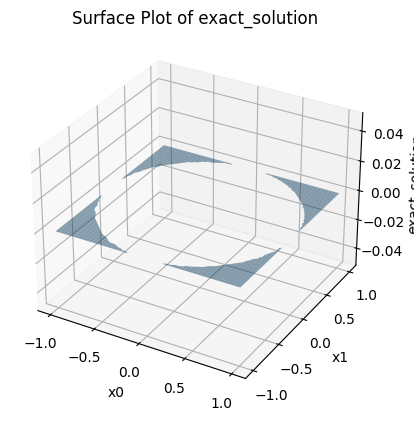

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Parameters
#b = 1.0  # Example value for b
grid_size = 100  # Number of points in each dimension

# Generate a grid of points
x0 = torch.linspace(-1, 1, grid_size)
x1 = torch.linspace(-1, 1, grid_size)
x0, x1 = torch.meshgrid(x0, x1)
x0 = x0.flatten()
x1 = x1.flatten()
points = torch.stack([x0, x1], dim=1)

# Evaluate the function at the grid points

#z = torch.cos(0.5*np.pi*torch.sqrt(points[:,0]**2 + points[:,1]**2)).unsqueeze(-1)*model(points) #
z = FQ(model, points) #
#z1 = reconstr_2D(points) # exact_solution(points)

# Reshape the results to match the grid
z = z.view(grid_size, grid_size).detach().numpy()
#z1= z1.view(grid_size, grid_size).detach().numpy()
x0 = x0.view(grid_size, grid_size).numpy()
x1 = x1.view(grid_size, grid_size).numpy()

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_surface(x0, x1, z1, cmap='viridis', alpha=0.5)
ax.plot_surface(x0, x1, z, alpha=0.5)

# Labels and title
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('exact_solution')
ax.set_title('Surface Plot of exact_solution')

plt.show()